In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/archive (7).zip" -d "/content/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/data/img_align_celeba/img_align_celeba/

In [3]:
import os
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision.models as models
import PIL
from torchvision.models import resnet50, ResNet50_Weights
import timm
from torch.utils.data import Dataset
import glob
import random
import torchvision

In [4]:
data_path = '/content/data/img_align_celeba/img_align_celeba'

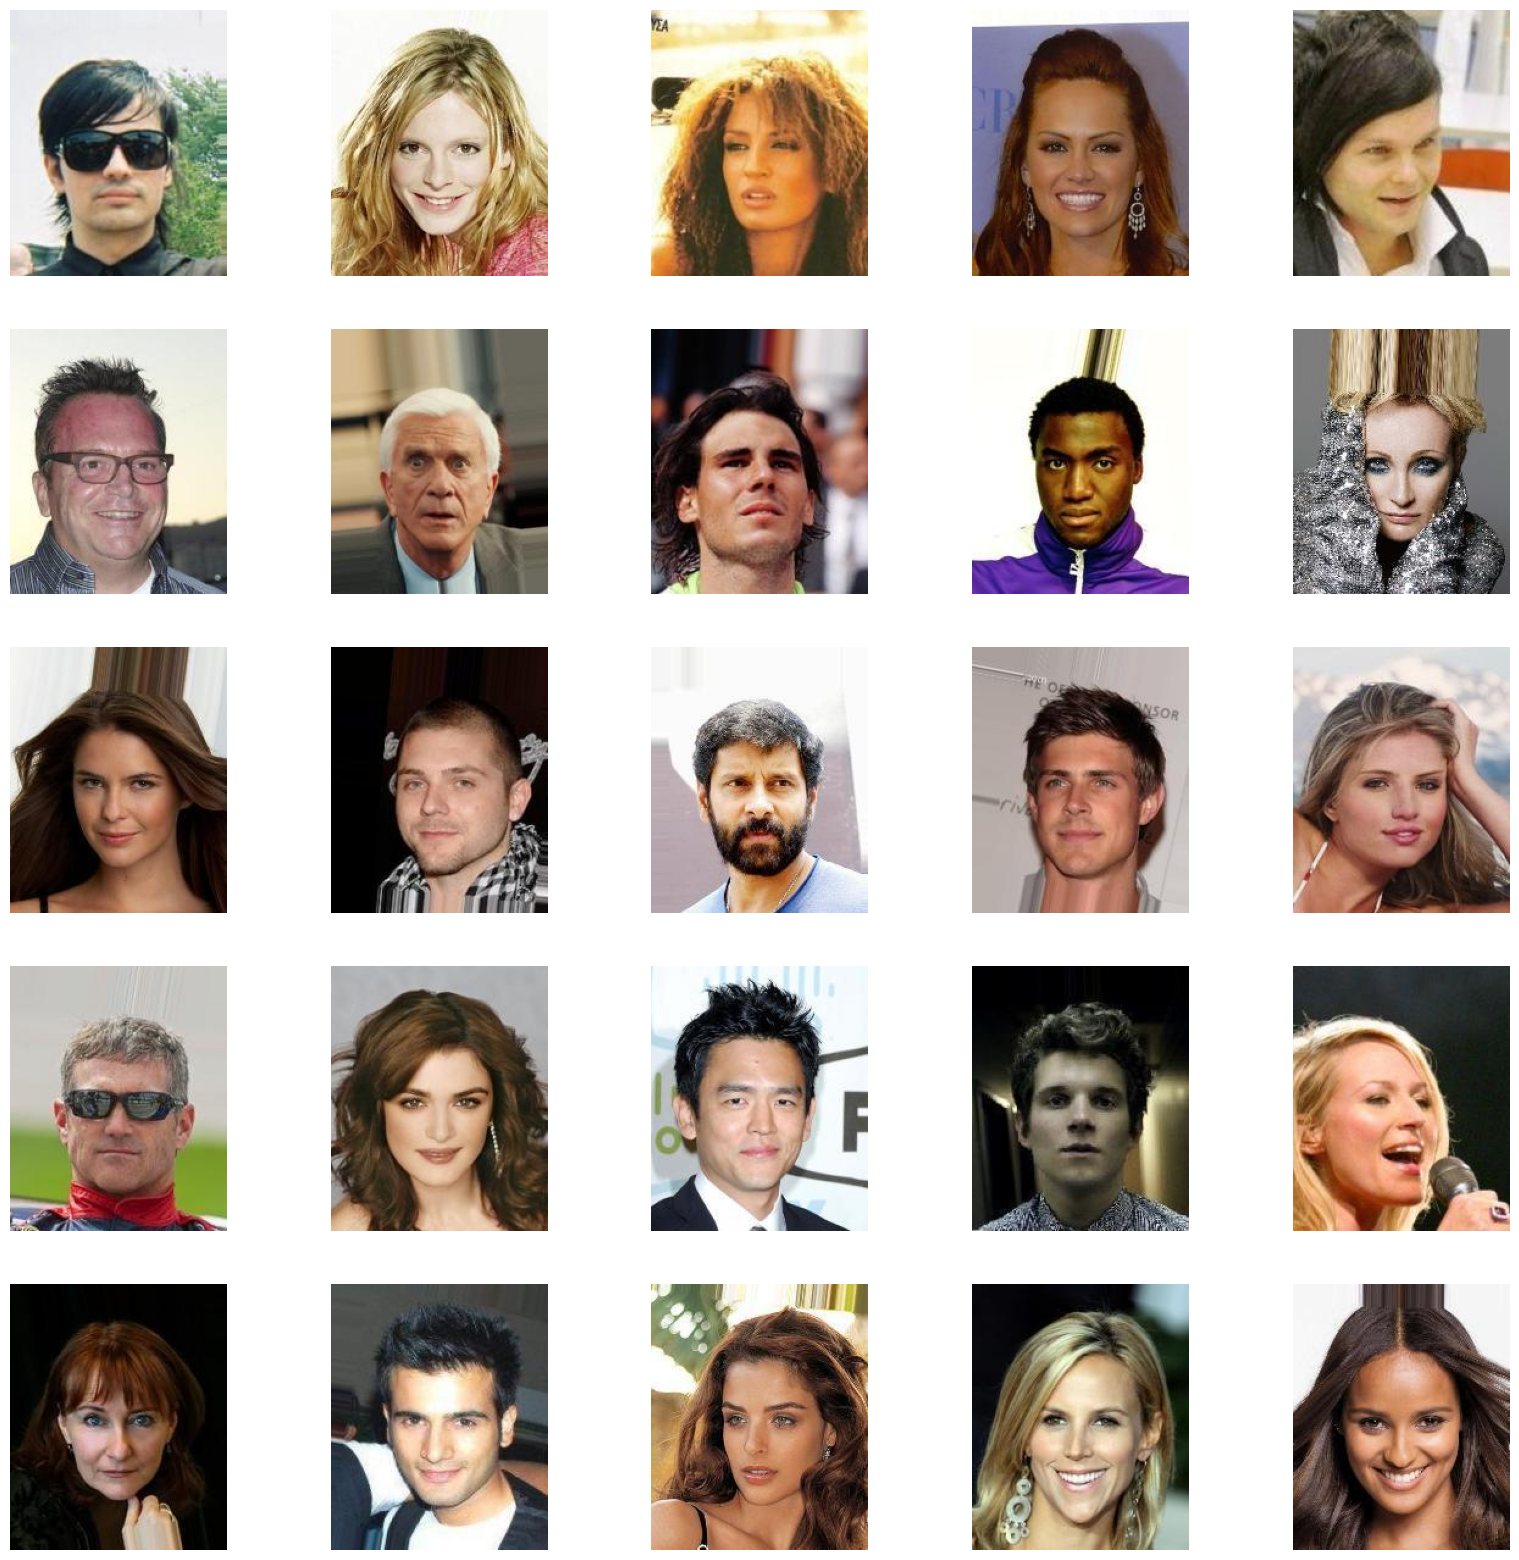

In [5]:
plt.figure(figsize=(20, 20))
for i, file in enumerate(os.listdir(data_path)[0:25]):
    fullpath = data_path + "/" + file
    img=mpimg.imread(fullpath)
    ax=plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(img)

In [6]:
torch.cuda.get_device_name(0)


'Tesla T4'

In [7]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [8]:
# Define transformations (resize, crop, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),  # Crop center to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CelebA dataset from the specified directory
dataset = CelebADataset(root_dir=data_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, pin_memory= True, num_workers=3)

# Check how many images are loaded
print(f"Total number of images loaded: {len(dataset)}")

Total number of images loaded: 202599


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, 1024*4*4)

        self.conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride =2)
        self.conv1_bn = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride =2)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride =2)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 3, kernel_size=2, stride =2)
        # self.conv1_bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()

    def forward(self, z):
        img = self.linear(z)
        img = img.view(img.size(0), 1024, 4, 4)
        img = self.relu(self.conv1_bn(self.conv1(img)))
        img = self.relu(self.conv2_bn(self.conv2(img)))
        img = self.relu(self.conv3_bn(self.conv3(img)))
        img = self.conv4(img)
        return img

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [11]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [12]:
g_accumulated_loss = []
d_accumulated_loss = []

In [13]:
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

In [14]:
# Training loop
def train(generator, discriminator, dataloader, epochs=5):
    g_total_loss = 0.0
    d_total_loss = 0.0
    pbar = tqdm(dataloader)
    for epoch in range(epochs):
        for i, imgs in enumerate(pbar):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_total_loss = d_total_loss + d_loss.item()
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_total_loss = g_total_loss + g_loss.item()
            g_loss.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        save_generated_images(generator, epoch, device)
        g_accumulated_loss.append(g_total_loss)
        d_accumulated_loss.append(d_total_loss)

  0%|          | 1/396 [00:04<31:08,  4.73s/it]

[Epoch 0/20] [Batch 0/396] [D loss: 0.6893123388290405] [G loss: 2.3676609992980957]


 26%|██▌       | 101/396 [01:01<04:11,  1.17it/s]

[Epoch 0/20] [Batch 100/396] [D loss: 0.509998619556427] [G loss: 4.917628288269043]


 51%|█████     | 201/396 [01:58<02:17,  1.42it/s]

[Epoch 0/20] [Batch 200/396] [D loss: 0.26116567850112915] [G loss: 2.3538613319396973]


 76%|███████▌  | 301/396 [02:54<01:06,  1.44it/s]

[Epoch 0/20] [Batch 300/396] [D loss: 0.35648107528686523] [G loss: 2.224569320678711]


100%|██████████| 396/396 [03:45<00:00,  1.76it/s]


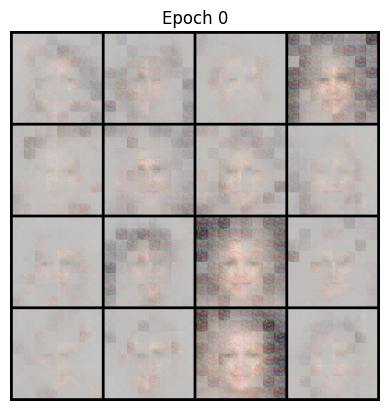

[Epoch 1/20] [Batch 0/396] [D loss: 0.4388458728790283] [G loss: 1.903207778930664]
[Epoch 1/20] [Batch 100/396] [D loss: 0.4741540253162384] [G loss: 1.2643945217132568]
[Epoch 1/20] [Batch 200/396] [D loss: 0.45743387937545776] [G loss: 2.4634475708007812]
[Epoch 1/20] [Batch 300/396] [D loss: 0.45217564702033997] [G loss: 1.6055059432983398]


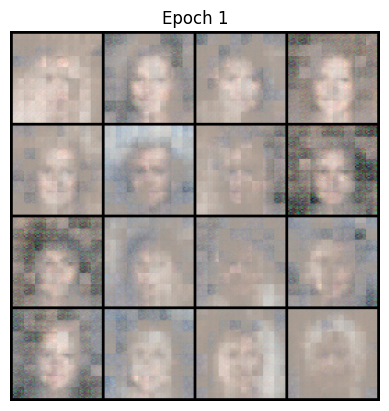

[Epoch 2/20] [Batch 0/396] [D loss: 0.43045923113822937] [G loss: 1.9373176097869873]
[Epoch 2/20] [Batch 100/396] [D loss: 0.49640727043151855] [G loss: 2.6008400917053223]
[Epoch 2/20] [Batch 200/396] [D loss: 0.4804214835166931] [G loss: 1.5657975673675537]
[Epoch 2/20] [Batch 300/396] [D loss: 0.3911847174167633] [G loss: 1.623218059539795]


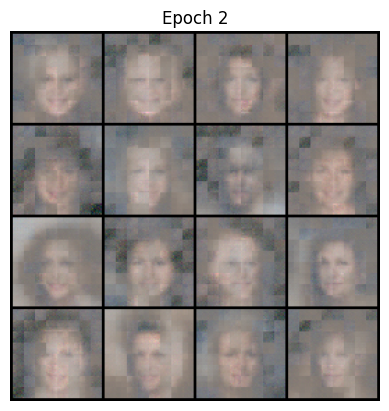

[Epoch 3/20] [Batch 0/396] [D loss: 0.40373754501342773] [G loss: 1.4659180641174316]
[Epoch 3/20] [Batch 100/396] [D loss: 0.4793272018432617] [G loss: 2.620910882949829]
[Epoch 3/20] [Batch 200/396] [D loss: 0.5097678899765015] [G loss: 3.757082939147949]
[Epoch 3/20] [Batch 300/396] [D loss: 0.2204936444759369] [G loss: 2.1742358207702637]


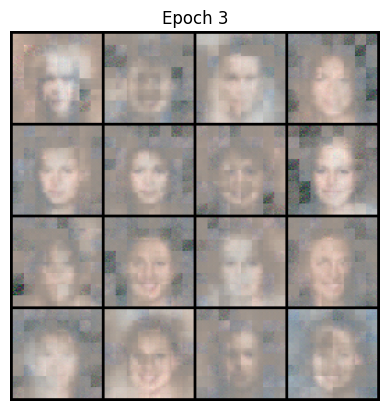

[Epoch 4/20] [Batch 0/396] [D loss: 0.5237086415290833] [G loss: 5.086615562438965]
[Epoch 4/20] [Batch 100/396] [D loss: 0.2930385172367096] [G loss: 2.5933947563171387]
[Epoch 4/20] [Batch 200/396] [D loss: 0.3956122398376465] [G loss: 2.12990140914917]
[Epoch 4/20] [Batch 300/396] [D loss: 0.577702522277832] [G loss: 1.0712213516235352]


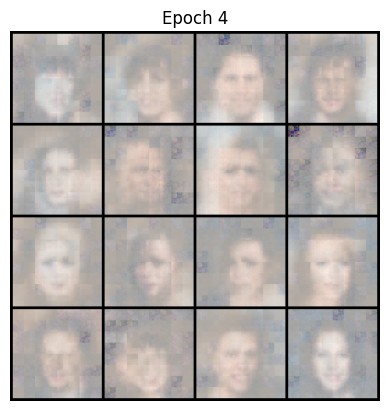

[Epoch 5/20] [Batch 0/396] [D loss: 0.39177268743515015] [G loss: 1.2183847427368164]
[Epoch 5/20] [Batch 100/396] [D loss: 0.3789884150028229] [G loss: 1.500897765159607]
[Epoch 5/20] [Batch 200/396] [D loss: 0.2772568166255951] [G loss: 1.7466849088668823]
[Epoch 5/20] [Batch 300/396] [D loss: 0.42771467566490173] [G loss: 1.2348723411560059]


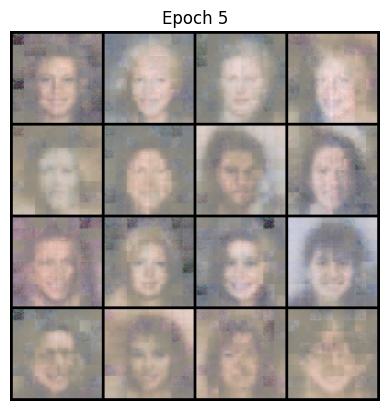

[Epoch 6/20] [Batch 0/396] [D loss: 0.27962470054626465] [G loss: 1.6167681217193604]
[Epoch 6/20] [Batch 100/396] [D loss: 0.22869618237018585] [G loss: 2.6085357666015625]
[Epoch 6/20] [Batch 200/396] [D loss: 0.12400639057159424] [G loss: 2.7144718170166016]
[Epoch 6/20] [Batch 300/396] [D loss: 0.3960062265396118] [G loss: 1.9617931842803955]


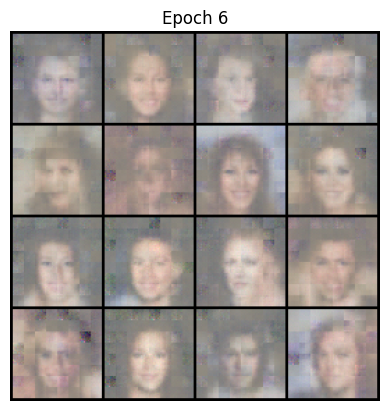

[Epoch 7/20] [Batch 0/396] [D loss: 0.3914090394973755] [G loss: 1.5864845514297485]
[Epoch 7/20] [Batch 100/396] [D loss: 0.3213726878166199] [G loss: 2.3427958488464355]
[Epoch 7/20] [Batch 200/396] [D loss: 0.3827783465385437] [G loss: 1.9725868701934814]
[Epoch 7/20] [Batch 300/396] [D loss: 0.4300597012042999] [G loss: 2.8396987915039062]


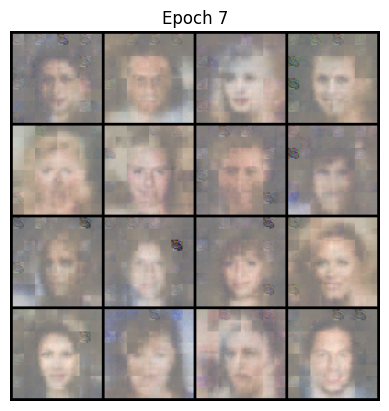

[Epoch 8/20] [Batch 0/396] [D loss: 0.13684335350990295] [G loss: 2.9285738468170166]
[Epoch 8/20] [Batch 100/396] [D loss: 0.3084515333175659] [G loss: 1.2473162412643433]
[Epoch 8/20] [Batch 200/396] [D loss: 0.4910832345485687] [G loss: 5.558294773101807]
[Epoch 8/20] [Batch 300/396] [D loss: 0.39445337653160095] [G loss: 1.8611416816711426]


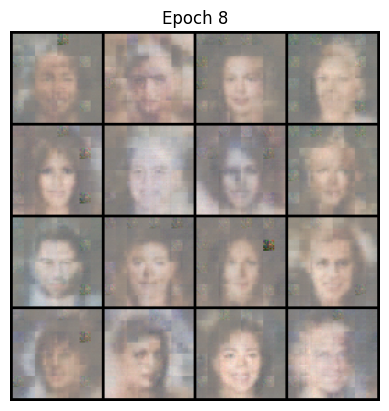

[Epoch 9/20] [Batch 0/396] [D loss: 0.4200424551963806] [G loss: 1.3293890953063965]
[Epoch 9/20] [Batch 100/396] [D loss: 0.30339378118515015] [G loss: 3.508227825164795]
[Epoch 9/20] [Batch 200/396] [D loss: 0.42754343152046204] [G loss: 1.8846348524093628]
[Epoch 9/20] [Batch 300/396] [D loss: 0.3564467430114746] [G loss: 2.1274595260620117]


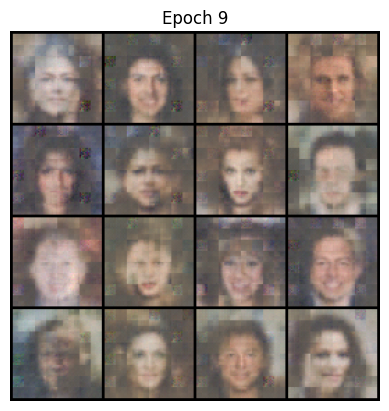

[Epoch 10/20] [Batch 0/396] [D loss: 0.4829217791557312] [G loss: 1.6820495128631592]
[Epoch 10/20] [Batch 100/396] [D loss: 0.4324262738227844] [G loss: 4.08302116394043]
[Epoch 10/20] [Batch 200/396] [D loss: 0.2997376322746277] [G loss: 1.9512503147125244]
[Epoch 10/20] [Batch 300/396] [D loss: 0.33282768726348877] [G loss: 1.4645756483078003]


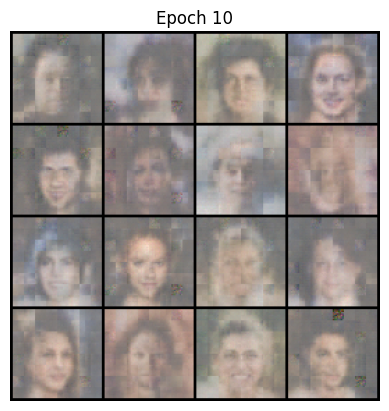

[Epoch 11/20] [Batch 0/396] [D loss: 0.454245924949646] [G loss: 1.6559510231018066]
[Epoch 11/20] [Batch 100/396] [D loss: 0.4797626733779907] [G loss: 1.3275034427642822]
[Epoch 11/20] [Batch 200/396] [D loss: 0.4795798361301422] [G loss: 2.0167484283447266]
[Epoch 11/20] [Batch 300/396] [D loss: 0.5394203662872314] [G loss: 1.1332910060882568]


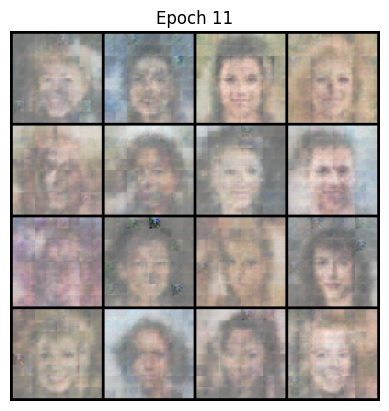

[Epoch 12/20] [Batch 0/396] [D loss: 0.48003971576690674] [G loss: 1.179483413696289]
[Epoch 12/20] [Batch 100/396] [D loss: 0.5235687494277954] [G loss: 0.9589005708694458]
[Epoch 12/20] [Batch 200/396] [D loss: 0.4936528503894806] [G loss: 1.43373703956604]
[Epoch 12/20] [Batch 300/396] [D loss: 0.5342361927032471] [G loss: 1.6409615278244019]


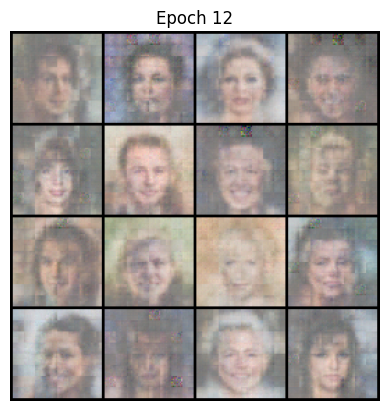

[Epoch 13/20] [Batch 0/396] [D loss: 0.45804455876350403] [G loss: 1.656814455986023]
[Epoch 13/20] [Batch 100/396] [D loss: 0.545671284198761] [G loss: 1.2413467168807983]
[Epoch 13/20] [Batch 200/396] [D loss: 0.29157140851020813] [G loss: 1.6481575965881348]
[Epoch 13/20] [Batch 300/396] [D loss: 0.5209107398986816] [G loss: 0.7603694200515747]


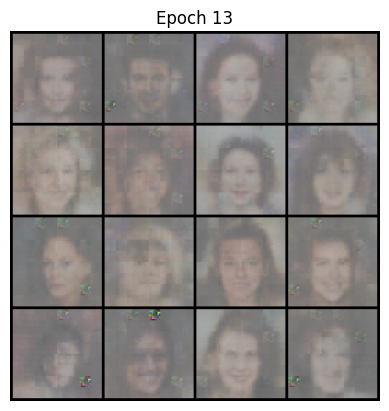

[Epoch 14/20] [Batch 0/396] [D loss: 0.5800982117652893] [G loss: 0.7584986090660095]
[Epoch 14/20] [Batch 100/396] [D loss: 0.5425263047218323] [G loss: 1.0596623420715332]
[Epoch 14/20] [Batch 200/396] [D loss: 0.4931698143482208] [G loss: 1.3924012184143066]
[Epoch 14/20] [Batch 300/396] [D loss: 0.7317104339599609] [G loss: 1.004662036895752]


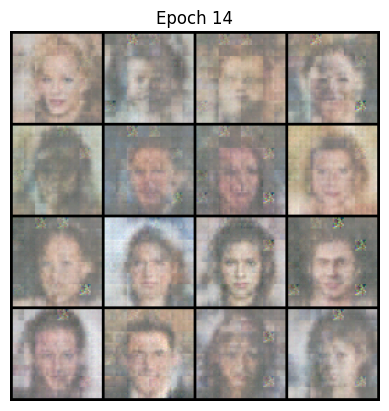

[Epoch 15/20] [Batch 0/396] [D loss: 0.5530007481575012] [G loss: 1.3287065029144287]
[Epoch 15/20] [Batch 100/396] [D loss: 0.6074174046516418] [G loss: 1.0873602628707886]
[Epoch 15/20] [Batch 200/396] [D loss: 0.5754563212394714] [G loss: 1.0820138454437256]
[Epoch 15/20] [Batch 300/396] [D loss: 0.5499143600463867] [G loss: 1.1655292510986328]


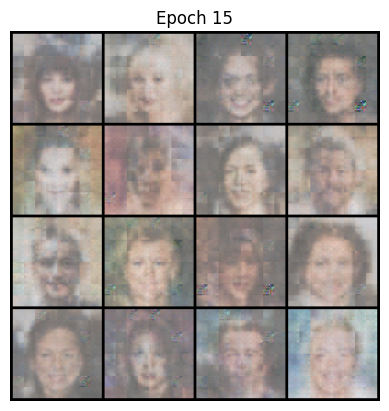

[Epoch 16/20] [Batch 0/396] [D loss: 0.554863452911377] [G loss: 1.303637981414795]
[Epoch 16/20] [Batch 100/396] [D loss: 0.46775534749031067] [G loss: 1.7941815853118896]
[Epoch 16/20] [Batch 200/396] [D loss: 0.5251911878585815] [G loss: 1.688101053237915]
[Epoch 16/20] [Batch 300/396] [D loss: 0.42292356491088867] [G loss: 2.802372932434082]


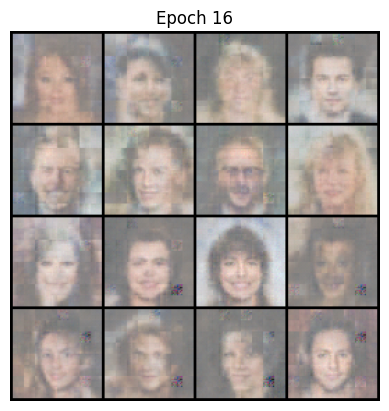

[Epoch 17/20] [Batch 0/396] [D loss: 0.5736557245254517] [G loss: 1.5176458358764648]
[Epoch 17/20] [Batch 100/396] [D loss: 0.8737110495567322] [G loss: 1.1276936531066895]
[Epoch 17/20] [Batch 200/396] [D loss: 0.49672386050224304] [G loss: 1.241619348526001]
[Epoch 17/20] [Batch 300/396] [D loss: 0.4711110293865204] [G loss: 1.1779139041900635]


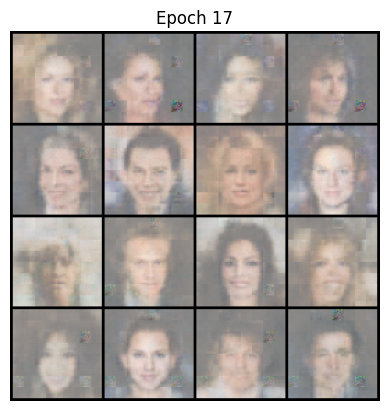

[Epoch 18/20] [Batch 0/396] [D loss: 0.48149651288986206] [G loss: 1.623826265335083]
[Epoch 18/20] [Batch 100/396] [D loss: 0.3318670392036438] [G loss: 1.7229254245758057]
[Epoch 18/20] [Batch 200/396] [D loss: 0.4723407030105591] [G loss: 1.3402124643325806]
[Epoch 18/20] [Batch 300/396] [D loss: 0.5211584568023682] [G loss: 1.3595471382141113]


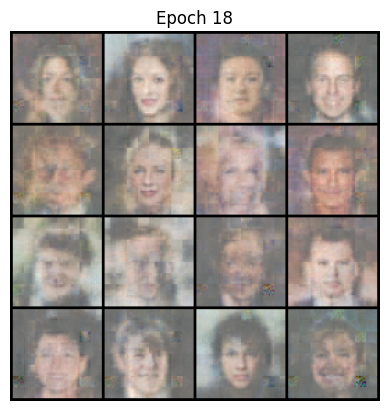

[Epoch 19/20] [Batch 0/396] [D loss: 0.391695499420166] [G loss: 1.9766182899475098]
[Epoch 19/20] [Batch 100/396] [D loss: 0.40807652473449707] [G loss: 1.870883822441101]
[Epoch 19/20] [Batch 200/396] [D loss: 0.5039304494857788] [G loss: 1.6834046840667725]
[Epoch 19/20] [Batch 300/396] [D loss: 0.36805135011672974] [G loss: 1.2875769138336182]


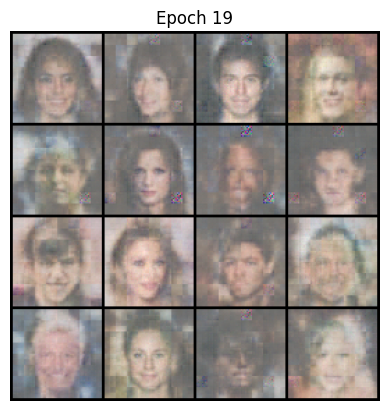

In [15]:
train(generator, discriminator, dataloader, epochs=20)

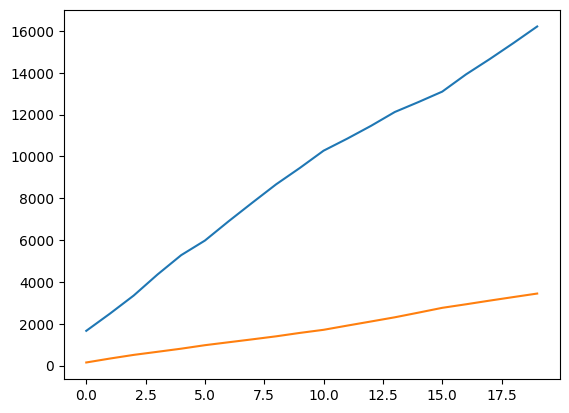

In [16]:
plt.plot(g_accumulated_loss)
plt.plot(d_accumulated_loss)
plt.show()